Modele autoregressif vectoriel après désaisonnalisation avec un GAM et 10 noeuds

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from matplotlib import cm
from matplotlib.colors import ListedColormap

In [2]:
stations_debit = pd.read_csv("../Data/Base/Stations_Debit.csv")
liste_stations = list(stations_debit["Code station"])

mesures_train_X = pd.read_csv("../Data/Base/Mesures_Train_X.csv")
mesures_train_X["Date"] = pd.to_datetime(mesures_train_X["Date"], format = "%Y/%m/%d %H:%M:%S")
mesures_train_Y = pd.read_csv("../Data/Base/Mesures_Train_Y.csv")
mesures_train_Y["Date"] = pd.to_datetime(mesures_train_Y["Date"], format = "%Y/%m/%d %H:%M:%S")

train_split_X = pd.read_csv("../Data/Base/Index_CV_X.csv")
train_split_Y = pd.read_csv("../Data/Base/Index_CV_Y.csv")

mesures_test_X = pd.read_csv("../Data/Base/Mesures_Test_X.csv")
mesures_test_X["Date"] = pd.to_datetime(mesures_test_X["Date"], format = "%Y/%m/%d %H:%M:%S")
mesures_test_Y = pd.read_csv("../Data/Base/Mesures_Test_Y.csv")
mesures_test_Y["Date"] = pd.to_datetime(mesures_test_Y["Date"], format = "%Y/%m/%d %H:%M:%S")

In [3]:
%run Eval_fcts.py

# Fonctions

In [4]:
%run Regression_GAM_Gamma.py
%run Regression_VAR.py

# Selection de modele

### AIC/BIC

In [5]:
n_knots = 10

aic_scores = []
bic_scores = []
for curr_p in tqdm(range(1, 16)):
    spline_fit = fct_Regression_SplineGamma_fit(mesures_train_X, liste_stations, n_knots)
    mesures_train_X_residus = fct_Regression_SplineGamma_residus(spline_fit, mesures_train_X, liste_stations)
    model_VAR = VAR(mesures_train_X_residus[liste_stations])
    fit_VAR = model_VAR.fit(curr_p)
    
    aic_scores.append(fit_VAR.aic)
    bic_scores.append(fit_VAR.bic)
scores = pd.DataFrame({"Lag": range(1, 16), "AIC": aic_scores, "BIC": bic_scores})
scores

100%|██████████| 15/15 [04:35<00:00, 18.40s/it]


,Lag,AIC,BIC
0,1,111.501838,112.694480
1,2,101.999609,104.341259
2,3,100.579115,104.070300
3,4,100.069141,104.710391
4,5,99.932094,105.723937
5,6,99.880705,106.823672
6,7,99.895046,107.989665
7,8,99.953015,109.199818
8,9,100.005336,110.404852
9,10,100.112134,111.664895


In [6]:
scores.to_csv("../Data/GAMGamma_VAR/AIC_BIC_scores.csv",
              index=False)

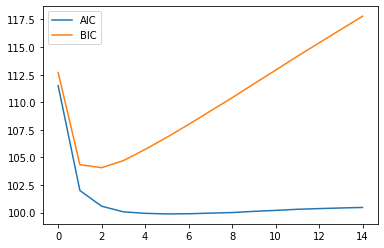

In [7]:
plt.plot(scores["AIC"], label = "AIC")
plt.plot(scores["BIC"], label = "BIC")
plt.legend()

### Validation croisée

In [ ]:
n_knots = 10

for curr_p in tqdm(range(1,8)):
    cv_scores_RMSE = pd.DataFrame({"Code station": liste_stations})
    cv_scores_MAE = pd.DataFrame({"Code station": liste_stations})
    cv_scores_R2 = pd.DataFrame({"Code station": liste_stations})
    
    for curr_split in range(9):
        
        # Entraintement
        curr_train_X = mesures_train_X[train_split_X["Train_" + str(curr_split)]]
        curr_train_Y = mesures_train_Y[train_split_Y["Train_" + str(curr_split)]]

        spline_fit = fct_Regression_SplineGamma_fit(curr_train_X, liste_stations, n_knots)
        mesures_train_X_residus = fct_Regression_SplineGamma_residus(spline_fit, curr_train_X, liste_stations)
        model_VAR = VAR(mesures_train_X_residus[liste_stations])
        fit_VAR = model_VAR.fit(curr_p)

        # Prédictions
        curr_test_X = mesures_train_X[train_split_X["Test_" + str(curr_split)]]
        curr_test_X_residus = fct_Regression_SplineGamma_residus(spline_fit, curr_test_X, liste_stations)
        curr_test_Y = mesures_train_Y[train_split_Y["Test_" + str(curr_split)]]
        liste_dates = curr_test_Y["Date"]
        predictions_Y_residus = fct_Regression_VAR_predict(curr_test_X_residus, fit_VAR, curr_p, liste_dates, liste_stations)
        # On rajoute la compo saisonnalité
        predictions_Y_saisonnalite = fct_Regression_SplineGamma_predict(spline_fit, liste_dates, liste_stations)
        predictions_Y = predictions_Y_residus[["Date"]].copy()
        for code in liste_stations:
            predictions_Y[code] = predictions_Y_residus[code].values + predictions_Y_saisonnalite[code].values
            
        # Scores
        curr_RMSE = fct_RMSE(curr_test_Y, predictions_Y, liste_stations)
        cv_scores_RMSE["Split_" + str(curr_split)] = curr_RMSE["RMSE"].values
        curr_MAE = fct_MAE(curr_test_Y, predictions_Y, liste_stations)
        cv_scores_MAE["Split_" + str(curr_split)] = curr_MAE["MAE"].values
        curr_R2 = fct_R2(curr_test_Y, predictions_Y, liste_stations)
        cv_scores_R2["Split_" + str(curr_split)] = curr_R2["R2"].values

    cv_moyen_RMSE = []
    cv_moyen_MAE = []
    cv_moyen_R2 = []

    for code in liste_stations:
        score_RMSE = np.mean(cv_scores_RMSE[cv_scores_RMSE["Code station"] == code][["Split_" + str(i) for i in range(9)]].iloc[0,:])
        cv_moyen_RMSE.append(score_RMSE)
        score_MAE = np.mean(cv_scores_MAE[cv_scores_MAE["Code station"] == code][["Split_" + str(i) for i in range(9)]].iloc[0,:])
        cv_moyen_MAE.append(score_MAE)
        score_R2 = np.mean(cv_scores_R2[cv_scores_R2["Code station"] == code][["Split_" + str(i) for i in range(9)]].iloc[0,:])
        cv_moyen_R2.append(score_R2)

    cv_scores_RMSE["Moyenne"] = cv_moyen_RMSE
    cv_scores_RMSE.to_csv("../Data/GAMGamma_VAR/CV_RMSE_p_" + str(curr_p).rjust(2, "0") + ".csv",
                          index=False)
    cv_scores_MAE["Moyenne"] = cv_moyen_MAE
    cv_scores_MAE.to_csv("../Data/GAMGamma_VAR/CV_MAE_p_" + str(curr_p).rjust(2, "0") + ".csv",
                          index=False)
    cv_scores_R2["Moyenne"] = cv_moyen_R2
    cv_scores_R2.to_csv("../Data/GAMGamma_VAR/CV_R2_p_" + str(curr_p).rjust(2, "0") + ".csv",

                        index=False)

  0%|          | 0/7 [00:00<?, ?it/s]

### Selection modele

In [ ]:
n_cours_eau = 3
cours_eau = list(np.unique(stations_debit["Cours eau"]))
cours_eau_cmap = cm.get_cmap(ListedColormap(["red", "green", "blue"]))
cours_eau_couleur = pd.DataFrame({"Cours eau": cours_eau, "Index": range(n_cours_eau), "Couleur": ["red", "green", "blue"]})
cours_eau_couleur

In [ ]:
cv_moyen = pd.DataFrame()

for curr_p in range(1, 8):
    curr_moyen = {}
    cv_scores = pd.read_csv("../Data/GAMGamma_VAR/CV_RMSE_p_" + str(curr_p).rjust(2, "0") + ".csv")
    for code in liste_stations:
        curr_moyen[code] = list(cv_scores[cv_scores["Code station"] == code]["Moyenne"])
    curr_moyen = pd.DataFrame(curr_moyen)
    curr_moyen["Lag"] = curr_p
    cv_moyen = pd.concat([cv_moyen, curr_moyen])
    
fig, axs = plt.subplots(n_cours_eau, 1, figsize = (15,5))
for i in range(n_cours_eau):
    stations = list(stations_debit[stations_debit["Cours eau"] == list(cours_eau_couleur[cours_eau_couleur["Index"] == i]["Cours eau"])[0]]["Code station"])
    for code in stations:
        axs[i].plot(cv_moyen["Lag"], cv_moyen[code],
                   color = cours_eau_cmap(i))
plt.show()

In [ ]:
cv_moyen = pd.DataFrame()

for curr_p in range(1, 8):
    curr_moyen = {}
    cv_scores = pd.read_csv("../Data/GAMGamma_VAR/CV_MAE_p_" + str(curr_p).rjust(2, "0") + ".csv")
    for code in liste_stations:
        curr_moyen[code] = list(cv_scores[cv_scores["Code station"] == code]["Moyenne"])
    curr_moyen = pd.DataFrame(curr_moyen)
    curr_moyen["Lag"] = curr_p
    cv_moyen = pd.concat([cv_moyen, curr_moyen])
    
fig, axs = plt.subplots(n_cours_eau, 1, figsize = (15,5))
for i in range(n_cours_eau):
    stations = list(stations_debit[stations_debit["Cours eau"] == list(cours_eau_couleur[cours_eau_couleur["Index"] == i]["Cours eau"])[0]]["Code station"])
    for code in stations:
        axs[i].plot(cv_moyen["Lag"], cv_moyen[code],
                   color = cours_eau_cmap(i))
plt.show()

In [ ]:
cv_moyen = pd.DataFrame()

for curr_p in range(1, 8):
    curr_moyen = {}
    cv_scores = pd.read_csv("../Data/GAMGamma_VAR/CV_R2_p_" + str(curr_p).rjust(2, "0") + ".csv")
    for code in liste_stations:
        curr_moyen[code] = list(cv_scores[cv_scores["Code station"] == code]["Moyenne"])
    curr_moyen = pd.DataFrame(curr_moyen)
    curr_moyen["Lag"] = curr_p
    cv_moyen = pd.concat([cv_moyen, curr_moyen])
    
fig, axs = plt.subplots(n_cours_eau, 1, figsize = (15,5))
for i in range(n_cours_eau):
    stations = list(stations_debit[stations_debit["Cours eau"] == list(cours_eau_couleur[cours_eau_couleur["Index"] == i]["Cours eau"])[0]]["Code station"])
    for code in stations:
        axs[i].plot(cv_moyen["Lag"], cv_moyen[code],
                   color = cours_eau_cmap(i))
plt.show()

# Test

In [ ]:
p = 2

In [ ]:
# Entrainement
spline_fit = fct_Regression_SplineGamma_fit(mesures_test_X, liste_stations, n_knots)
mesures_test_X_residus = fct_Regression_SplineGamma_residus(spline_fit, mesures_test_X, liste_stations)
model_VAR = VAR(mesures_test_X_residus[liste_stations])
fit_VAR = model_VAR.fit(p)

# Prédictions
liste_dates = mesures_test_Y["Date"]
predictions_test_Y_residus = fct_Regression_VAR_predict(mesures_test_X_residus, fit_VAR, curr_p, liste_dates, liste_stations)
# On rajoute la compo saisonnalité
predictions_test_Y_saisonnalite = fct_Regression_SplineGamma_predict(spline_fit, liste_dates, liste_stations)
predictions_test_Y = predictions_test_Y_residus[["Date"]].copy()
for code in liste_stations:
    predictions_test_Y[code] = predictions_test_Y_residus[code].values + predictions_test_Y_saisonnalite[code].values

In [ ]:
n_stations = len(liste_stations)
fig, axs = plt.subplots(n_stations, 1, figsize = (15,30), sharex=True)
for i in range(n_stations):
    code = liste_stations[i]
    axs[i].plot(mesures_test_Y["Date"], mesures_test_Y[code], label = "True")
    axs[i].plot(predictions_test_Y_saisonnalite["Date"], predictions_test_Y_saisonnalite[code], label = "Saisonnalite")
    axs[i].plot(predictions_test_Y_residus["Date"], predictions_test_Y_residus[code], label = "Residus")
    axs[i].plot(predictions_test_Y["Date"], predictions_test_Y[code], label = "Predictions")
    axs[i].legend()

In [ ]:
scores_rmse = fct_RMSE(mesures_test_Y, predictions_test_Y, liste_stations)
scores_mae = fct_MAE(mesures_test_Y, predictions_test_Y, liste_stations)
scores_r2 = fct_R2(mesures_test_Y, predictions_test_Y, liste_stations)

test_scores = pd.DataFrame({"Code station": liste_stations,
                            "RMSE": scores_rmse["RMSE"],
                            "MAE": scores_mae["MAE"],
                            "R2": scores_r2["R2"]})
test_scores

In [ ]:
test_scores.to_csv("../Data/GAMGamma_VAR/Test_scores.csv",
                   index = False)